In [31]:
import horton
import numpy as np
import matplotlib.pyplot as plt

In [60]:
def do_mol(coords, zs, pseudo_numbers = None, outputfile=None):
    #horton.log.set_level(1)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array(coords)
    mol.numbers = np.array(zs)
    if pseudo_numbers is not None:
        mol.pseudo_numbers = np.array(pseudo_numbers)
    else:
        mol.pseudo_numbers = mol.numbers
    
    basisset = '6-31G'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    grid = horton.BeckeMolGrid(mol.coordinates, mol.numbers, mol.numbers, 'fine', mode='keep', random_rotate=False)
    terms = [
       horton.UTwoIndexTerm(kin, 'kin'),
        horton.UGridGroup(obasis, grid, [
            horton.UBeckeHartree(lmax=8),
            horton.ULibXCLDA('x'),
            horton.ULibXCLDA('c_vwn'),
        ]),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    ham = horton.UEffHam(terms, external)
    
    converged = False
    for solver in (horton.EDIIS2SCFSolver,horton.CDIISSCFSolver,horton.ODASCFSolver,  horton.EDIISSCFSolver, ):
        try:
            occ_model = horton.AufbauOccModel(sum(zs)/2, sum(zs)/2)
            print (sum(zs)/2, sum(zs)/2)
        
            occ_model.assign(orb_alpha, orb_beta)
            dm_alpha = orb_alpha.to_dm()
            dm_beta = orb_beta.to_dm()
            scf_solver = solver(1e-7, maxiter=100)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
        if converged:
            break
    mol.obasis = obasis
    mol.orb_alpha = orb_alpha
    mol.orb_beta = orb_beta
    return mol
class CUBE(object):
  def __init__(self, fname):
    f = open(fname, 'r')
    for i in range(2): f.readline() # echo comment
    tkns = f.readline().split() # number of atoms included in the file followed by the position of the origin of the volumetric data
    self.natoms = int(tkns[0])
    self.origin = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NX = int(tkns[0])
    self.X = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NY = int(tkns[0])
    self.Y = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    tkns = f.readline().split() #
    self.NZ = int(tkns[0])
    self.Z = np.array([float(tkns[1]),float(tkns[2]),float(tkns[3])])
    self.atoms = []
    for i in range(self.natoms):
      tkns = f.readline().split()
      self.atoms.append([tkns[0], tkns[2], tkns[3], tkns[4]])
    self.data = np.zeros((self.NX,self.NY,self.NZ))
    i=0
    for s in f:
      for v in s.split():
        self.data[i//(self.NY*self.NZ), (i//self.NZ)%self.NY, i%self.NZ] = float(v)
        i+=1
    if i != self.NX*self.NY*self.NZ: raise NameError("FSCK!")
def cube2grid(cube):
    X, Y, Z = np.mgrid[0:cube.X[0]*(cube.NX-1):complex(cube.NX), 0:cube.Y[1]*(cube.NY-1):complex(cube.NY), 0:cube.Z[2]*(cube.NZ-1):complex(cube.NZ)]
    positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T 
    return positions.copy()

In [6]:
cube = CUBE('data-density/box-20/lval-1.000000/DENSITY.cube')

In [10]:
pos = np.array(cube.atoms)[:,1:].astype(float)
zs = np.array(cube.atoms)[:,0].astype(int)

In [61]:
site = 0
delta = 0.1
pzs = zs.copy().astype(float)
pzs[site] += delta
up = do_mol(pos, zs, pzs)
pzs[site] -= 2*delta
print (pzs)
dn = do_mol(pos, zs, pzs)

Initialized: <horton.gbasis.cext.GOBasis object at 0x7f3717e75940>
  Number of basis functions         : 18
  Number of normalization constants : 44
  Maximum shell type                : 1
  Center     0 :  S6 S3 P3 S1 P1
  Center     1 :  S6 S3 P3 S1 P1

Performing a core Hamiltonian guess.

Preparing Becke-Lebedev molecular integration grid.
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Initialized: <horton.grid.molgrid.BeckeMolGrid object at 0x7f3717c1f510>
  Size               : 10628
  Switching function : k=3

(7, 7)
Starting restricted closed-shell EDIIS+DIIS-SCF
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Iter         Error        CN         Last nv Method          Energy       Change
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   0  2.78159e+00                          1     -106.4801462283213
   0  3.09040e+00

In [62]:
gridpos = cube2grid(cube)
rho_up = up.obasis.compute_grid_density_dm(up.get_dm_full(), gridpos)
rho_dn = dn.obasis.compute_grid_density_dm(dn.get_dm_full(), gridpos)

In [63]:
newrho = ((rho_up-rho_dn)/(2*delta)).reshape(cube.data.shape)

(-10, 10)

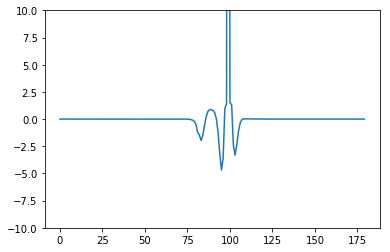

In [54]:
ys = rho_up.reshape(cube.data.shape).sum(axis=2).sum(axis=1)
#plt.plot(ys)
ys = rho_dn.reshape(cube.data.shape).sum(axis=2).sum(axis=1)
#plt.plot(ys)
ys = newrho.sum(axis=2).sum(axis=1)
plt.plot(ys)
plt.ylim(-10, 10)

(-10, 10)

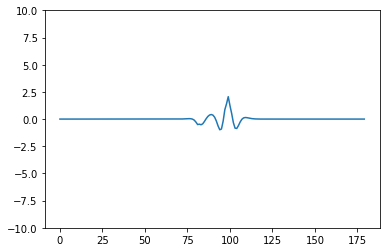

In [64]:
ys = rho_up.reshape(cube.data.shape).sum(axis=2).sum(axis=1)
#plt.plot(ys)
ys = rho_dn.reshape(cube.data.shape).sum(axis=2).sum(axis=1)
#plt.plot(ys)
ys = newrho.sum(axis=2).sum(axis=1)
plt.plot(ys)
plt.ylim(-10, 10)